In [1]:
#Load Packages
suppressPackageStartupMessages({ 
    library(ComplexHeatmap)
    library(RColorBrewer)
    library(tidyverse)
    library(circlize)
    library(factoextra)
    library(ggpubr)
    })

In [2]:
#function for plotting ggplot theme
theme_gy <- function (base_size = 23) 
{
    theme_bw(base_size = base_size) + theme(plot.title = element_text(hjust = 0.5, 
        size = (base_size + 2)), legend.title = element_text(face = "italic"), 
                                           legend.position = "none")
}
#function for plotting
fig.size <- function (height = 4, width = 4) 
{
    options(repr.plot.height = height, repr.plot.width = width)
}

In [3]:
## Filter the data into quartiles
quartile_filt = function(x){ 
    ifelse(x < 0.23, 0, 
          ifelse(x <= 0.55 & x >= 0.23, 0.5, 1))}

In [70]:
#Read in data 
M2 <- suppressMessages({ 
    read_csv("DeletionMatrix.csv")
    })
# Update with Cluster Identities
M2<- inner_join(M2, select(read_csv("meta_umap_adt_DQB1.clust.csv"), cell, UMAP1, UMAP2, cluster), by = "cell") %>% 
    inner_join(select(read_csv("meta_umap_DQB1.clust.csv"), cell, UMAP1, UMAP2, cluster), by = "cell") %>% 
inner_join(read_csv("FlowMatrix_Genes_ADT.csv"), by = "cell")

Rows: 1046 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): plate, cell_adt, Condition, MainCondition, RNA, cell
dbl (25): nUMI, nGenes, UMAP1, UMAP2, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 910 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): plate, cell, Condition, MainCondition, ADT, cell_ADT
dbl (26): nUMI, nGenes, pctMito, UMAP1, UMAP2, PC1, PC2, PC3, PC4, PC5, PC6,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2723 Columns: 194
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (19): cell, plate, cell_adt, Condition.x, 

In [71]:
# cluster.x defines the RNA clusters. 
M2$cluster.x %>% table

.
  0   1   2 
317 420   3 

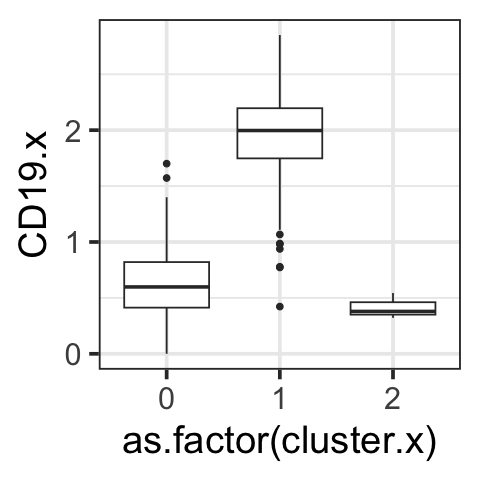

In [72]:
#Check Cluster ID.
fig.size(4,4)
M2 %>% ggplot(aes(as.factor(cluster.x), CD19.x)) + geom_boxplot() + theme_gy()

# Daudis + Jurkat Analysis

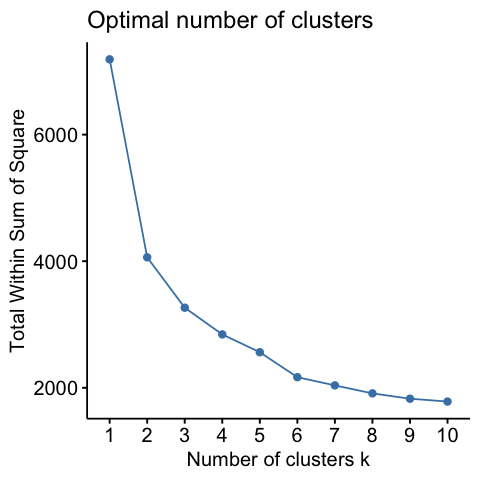

In [73]:
#Estimate number of kmean clusters in data. 
fviz_nbclust(M2[50:160], kmeans, method = "wss")

In [74]:
#Use Kmeans Clustering to create clusters + assign to dataframe
cluster <- kmeans(M2[50:160],10)
clusterID <- cluster$cluster # set cluster ID
M2 <- dplyr::mutate(M2, KClust = clusterID) # add to original dataframe
M2$KClust <- as.factor(M2$KClust) # make as factor

In [75]:
M2$KClust %>% table

.
  1   2   3   4   5   6   7   8   9  10 
 34  24  55  30 441  28  29  38  15  46 

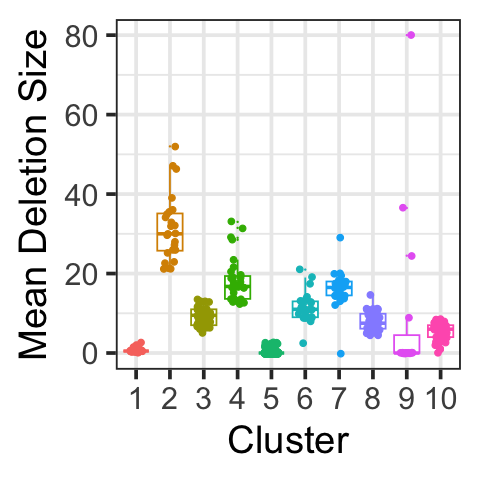

In [76]:
#quick plot of cluster by average deletion size
fig.size(4,4)
M2 %>% ggplot(aes(y=DQB1deletion_Mean, x = KClust, color = KClust)) + geom_boxplot(outlier.size = 0) + 
    geom_jitter(width = 0.2) + theme_gy() +
    xlab("Cluster") + ylab("Mean Deletion Size")
#+   scale_color_manual(values = c("grey", "#D4B9DA", "#C994C7", "#DF65B0"))

In [77]:
#Define Color
col_fun <- colorRamp2(c(0,1,2), c("white", "grey", "black"))

In [78]:
#Quick Heatmap
fig.size(10,10)
  g<-  Heatmap(
    M2[50:160], 
       cluster_columns = FALSE, 
        show_column_names = F, 
        row_split = factor(M2$KClust), 
        cluster_row_slices = FALSE, 
        show_row_dend = F, 
        show_row_names = F, 
      col = col_fun, 
    name = "%Modified Base", 
    row_title_rot = 0, 
    column_title = "HH Deletions Around DQB1", 
    border_gp = gpar(col = "black", lty = 1)
        )

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


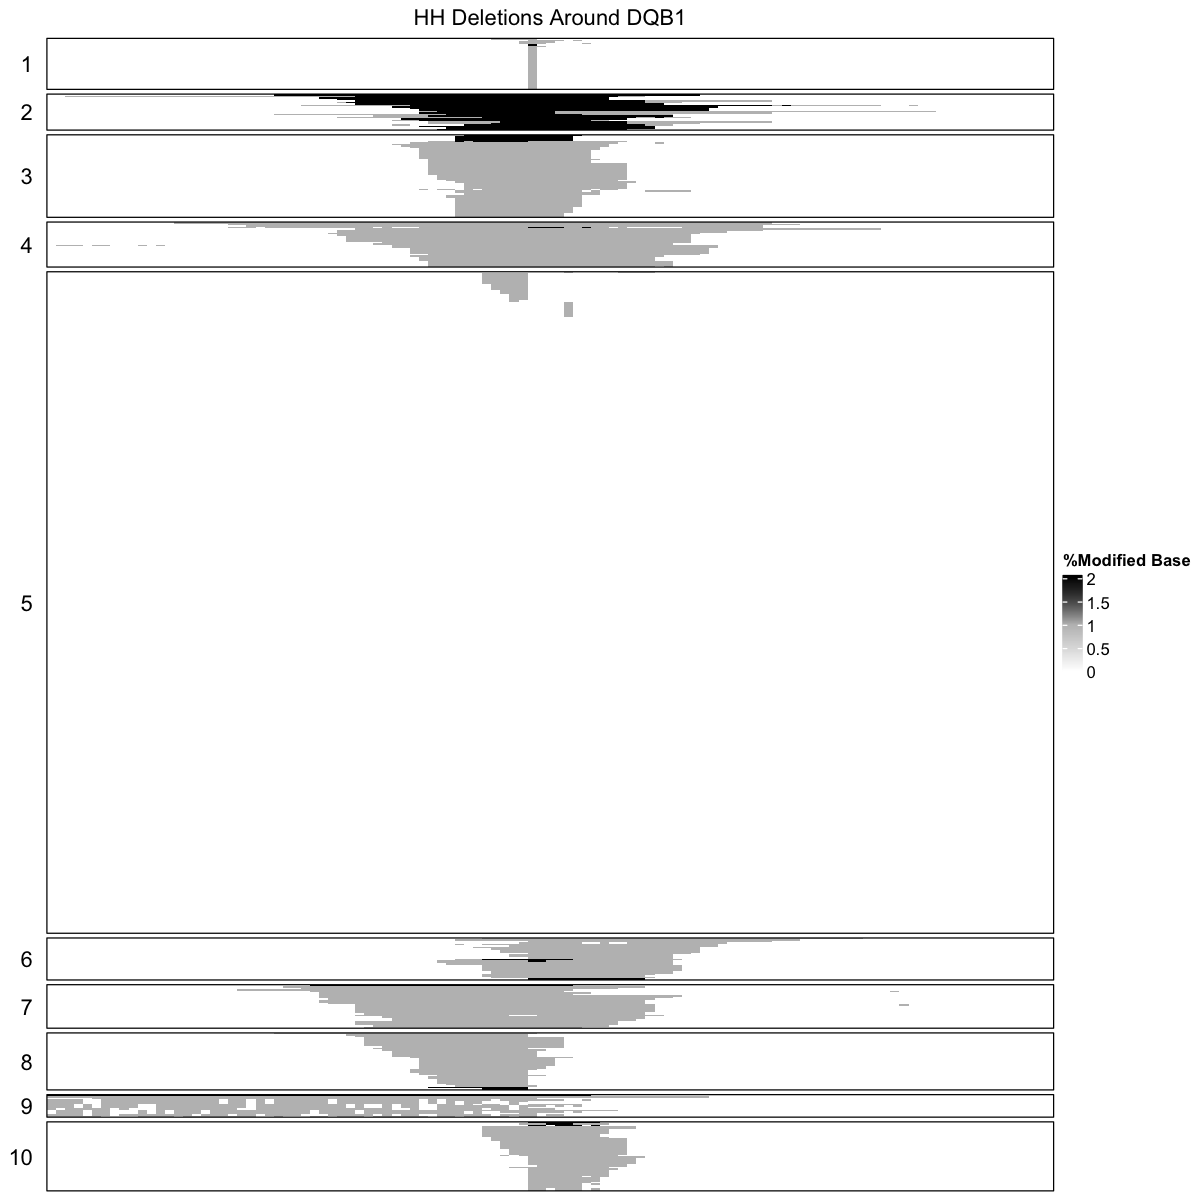

In [79]:
draw(g)

In [80]:
#Cluster 10 is defining insertion events
#Identify those cells and remove from analysis. 
IndelCells <- filter(M2, KClust ==9) %>% with(cell)
M2 <- filter(M2, !(cell %in% IndelCells))

In [ ]:
## Repeat Analysis 

In [81]:
#Use Kmeans Clustering to create clusters + assign to dataframe
cluster <- kmeans(M2[50:160],3)
clusterID <- cluster$cluster 
M2 <- dplyr::mutate(M2, KClust = clusterID)
M2$KClust <- as.factor(M2$KClust)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


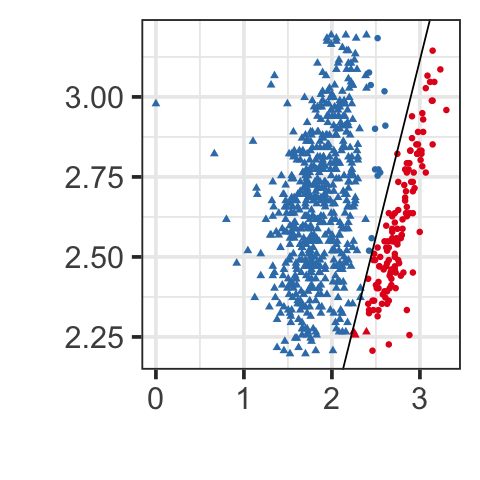

In [83]:
## Define new control vs CRISPR
fig.size(4,4)

M2 <- mutate(M2, Edited_Index2 = ifelse((1.105*log10(PB_CD45)-0.2) < log10(BV605_CD45), "CRISPR", "Control"))
M2 %>% filter(cluster.x != 2) %>% ggplot(aes(log10(PB_CD45), log10(BV605_CD45), shape = Edited_Index, color = Edited_Index2)) + geom_point() + 
theme_gy() +
geom_abline(intercept = -0.2, slope = 1.105) + 
#facet_grid(~cluster.x) + 
scale_color_manual(values = c(
          "Control" = "#E41A1C",
          "CRISPR" = "#377EB8",
          "1" = "#DD1C77", 
          "3" = "#C994C7",
          "2" = "grey40"))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
     # facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank()) + 
ylab("")
    


In [84]:
#Define colors
colors = structure(c("white", "grey", "black"), names = c("0", "1", "2"))

In [85]:
#re-order and rename based on size
#Define Order
order <- M2 %>% group_by(KClust) %>% summarize(Editing = mean(DQB1deletion_Mean)) %>% arrange(Editing) %>% with(KClust)
#Redefine the variable
M2$KClust <- factor(M2$KClust, level = order)

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


null device 
          1

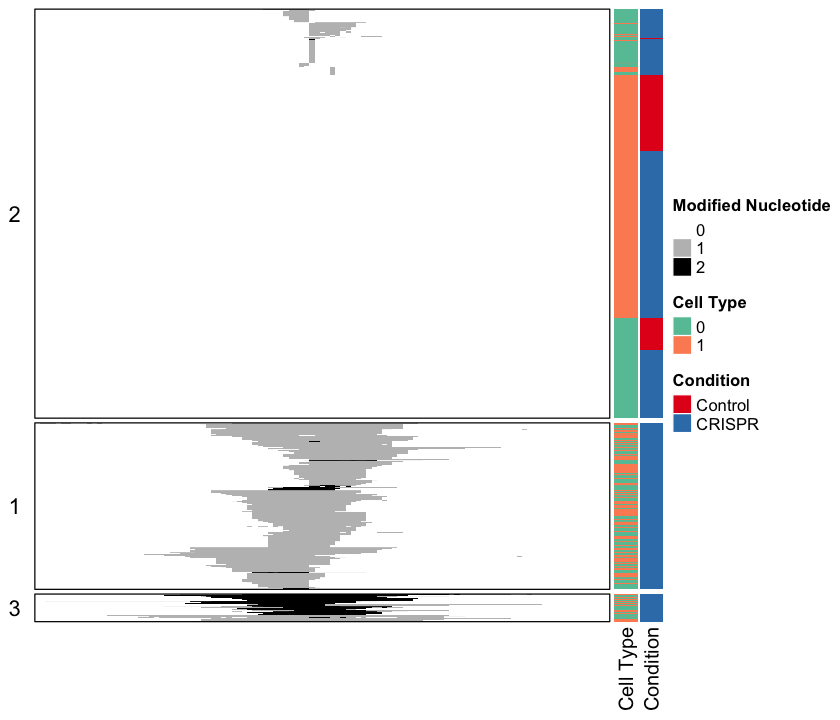

In [86]:
#plot heatmap
fig.size(6,7)
df<-na.omit(M2)
df <- filter(df, cluster.x != 2)
df <- arrange(df, DQB1deletion_Mean)
df <- arrange(df, Edited_Index2)
df <- arrange(df, cluster.x)
#pdf("M2.pdf", width = 7, height = 5.8)
Heatmap(
    df[50:160], 
       cluster_columns = FALSE, 
       right_annotation = rowAnnotation(#"DQB1" = (df$`HLA-DQB1`),
                                        #"FITC-DQB1" = log10(df$FITC_DQB1),
                                       # "Deletion Class" = df$KClust2,
                                        "Cell Type" = df$cluster.x,
                                        "Condition" = df$Edited_Index2,
                                        
                                        col = list(`DQB1` = colorRamp2(c(
                                                                       min(df$`HLA-DQB1`),
                                                                       max(df$`HLA-DQB1`)), 
                                                                       c("white", 
                                                                         "#08519C")), 
                                                   `Deletion Class` = c("Small" = "grey",
                                                               #"Medium" = "#D4B9DA", 
                                                               "Medium" = "#C994C7",
                                                               "Large" = "#DF65B0"),
                                                   `FITC-DQB1` = colorRamp2(c(min(log10(df$FITC_DQB1)),
                                                                       max(log10(df$FITC_DQB1))), 
                                                                     c("white", 
                                                                       "#08519C")), 
                                                   `Condition` = c("Control" = "#E41A1C", "CRISPR"= "#377EB8"), 
                                                   `Cell Type` = c("0" = "#66C2A5", "1" = "#FC8D62")
                                                   
                                                  
                                                   
                                                  
                                                   )
                                        ),
        #left_annotation = rowAnnotation("Cluster" = M$KClust,
         #                             col = list(
          #                            `Cluster` = c("1" = "#E41A1C",
           #                                         "2" = "#377EB8", 
            #                                        "3" = "#4DAF4A",
             #                                       "4" = "#984EA3"))),
        col = colors,
        show_column_names = F, 
        row_split = factor(df$KClust), 
        cluster_row_slices = F, 
        show_row_dend = F, 
        show_row_names = F, 
    name = "Modified Nucleotide", 
    row_title_rot = 0,  
    border_gp = gpar(col = "black", lty = 1)
        )
dev.off()

In [93]:
## ADD HDR data
M2 <- mutate(M2, DNA_well = paste0(Barcode_DNA, "_", Well_ID.x))
M2 <- mutate(M2, HDR = ifelse(DNA_well %in% HDRcells, "HDR", "Other"))

In [99]:
#plot heatmap - save as PDF
fig.size(6,7)
df<-na.omit(M2)
df <- filter(df, cluster.x != 2)
df <- arrange(df, DQB1deletion_Mean)
df <- arrange(df, Edited_Index2)
df <- arrange(df, cluster.x)
pdf("M2.pdf", width = 7, height = 5.8, compress = F)
Heatmap(
    df[50:160], 
       cluster_columns = FALSE, 
       right_annotation = rowAnnotation(#"DQB1" = (df$`HLA-DQB1`),
                                        #"FITC-DQB1" = log10(df$FITC_DQB1),
                                       # "Deletion Class" = df$KClust2,
                                        "Cell Type" = df$cluster.x,
                                        "Condition" = df$Edited_Index2,
                                        "HDR" = df$HDR,
                                        col = list(`DQB1` = colorRamp2(c(
                                                                       min(df$`HLA-DQB1`),
                                                                       max(df$`HLA-DQB1`)), 
                                                                       c("white", 
                                                                         "#08519C")), 
                                                   `Deletion Class` = c("Small" = "grey",
                                                               #"Medium" = "#D4B9DA", 
                                                               "Medium" = "#C994C7",
                                                               "Large" = "#DF65B0"),
                                                   `FITC-DQB1` = colorRamp2(c(min(log10(df$FITC_DQB1)),
                                                                       max(log10(df$FITC_DQB1))), 
                                                                     c("white", 
                                                                       "#08519C")), 
                                                   `Condition` = c("Control" = "#E41A1C", "CRISPR"= "#377EB8"), 
                                                   `Cell Type` = c("0" = "#66C2A5", "1" = "#FC8D62"), 
                                                   `HDR` = c("HDR" = "purple", "Other" = "white")
                                                   
                                                  
                                                   
                                                  
                                                   )
                                        ),
        #left_annotation = rowAnnotation("Cluster" = M$KClust,
         #                             col = list(
          #                            `Cluster` = c("1" = "#E41A1C",
           #                                         "2" = "#377EB8", 
            #                                        "3" = "#4DAF4A",
             #                                       "4" = "#984EA3"))),
        col = colors,
        show_column_names = F, 
        row_split = factor(df$KClust), 
        cluster_row_slices = F, 
        show_row_dend = F, 
        show_row_names = F, 
    name = "Modified Nucleotide", 
    row_title_rot = 0,  
    border_gp = gpar(col = "black", lty = 1)
        )
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2